In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
current_path = os.getcwd()
converted_path = current_path.replace('/', '\\')
print(converted_path)

\home\duong\git\DecodeItAll\bio_seman_seg\unet\drive


In [3]:
bio_seg_dir = "/".join(converted_path.split("\\")[:-2])
print(bio_seg_dir)
print(os.path.exists(bio_seg_dir))

/home/duong/git/DecodeItAll/bio_seman_seg
True


In [4]:
data_dir = bio_seg_dir + "/dataset/drive"
print(os.listdir(data_dir))

['test', 'training']


In [5]:
train_dir = data_dir + "/training"
test_dir = data_dir + "/test"

train_img_dir = train_dir + "/images"
train_mask_dir = train_dir + "/1st_manual"

test_img_dir = test_dir + "/images"

print(f"No. Train Img: {len(os.listdir(train_img_dir))}")
print(f"No. Train Msk: {len(os.listdir(train_mask_dir))}")
print(f"No. Test Img: {len(os.listdir(test_img_dir))}")

No. Train Img: 20
No. Train Msk: 20
No. Test Img: 20


In [6]:
class DriveDS(Dataset):
    def __init__(self, transform = None, target_transform = None):
        from glob import glob
        self.imgs = sorted(glob(train_img_dir + "/*"))
        self.msks = sorted(glob(train_mask_dir + "/*"))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20


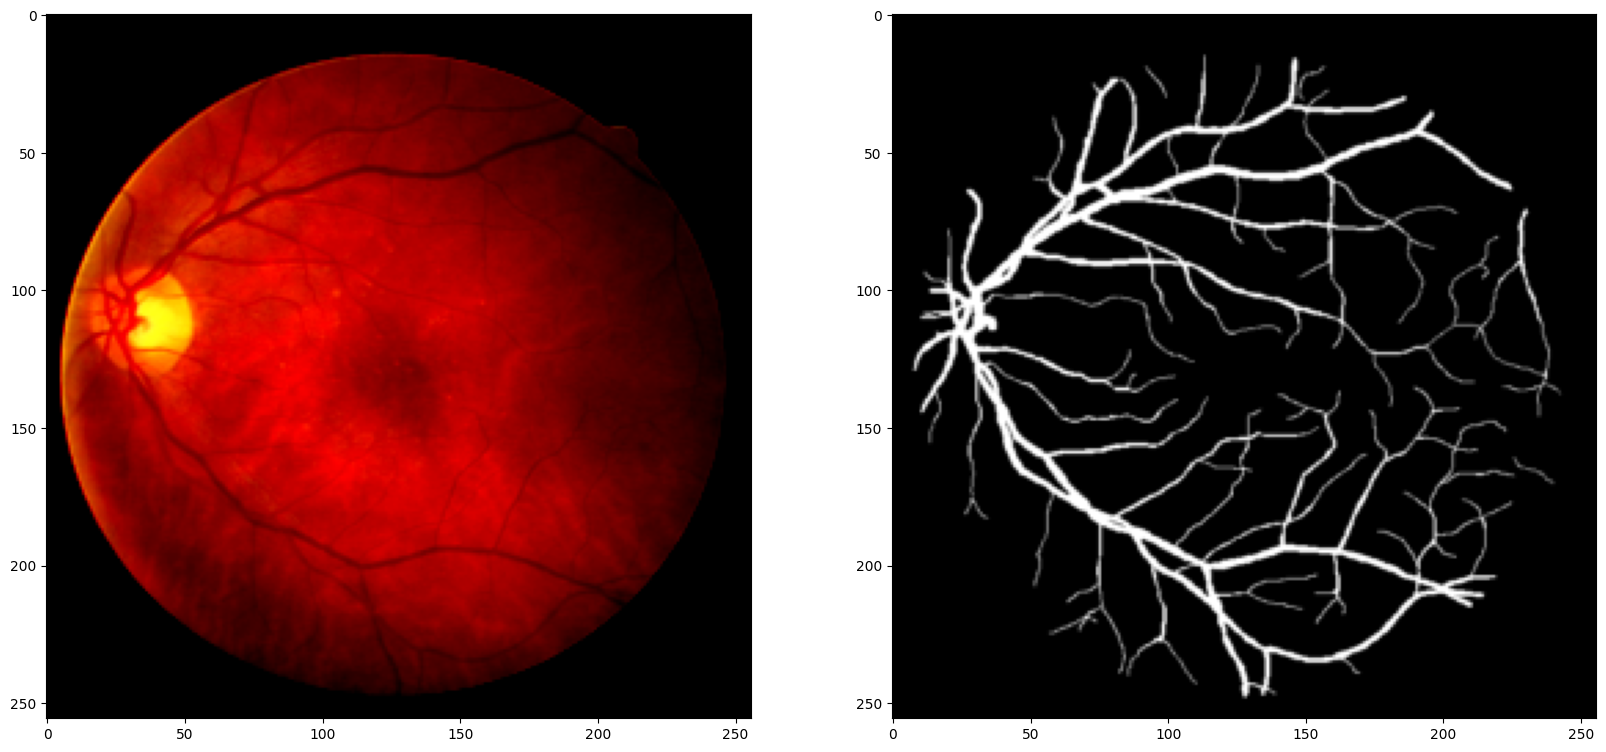

In [7]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

train_ds = DriveDS(transform = transform, target_transform=target_transform)

print(len(train_ds))

img, msk = train_ds[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(img.permute(1, -1, 0).numpy())
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [8]:
train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)

print(len(train_dl))

1


In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [10]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [11]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [12]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32)) #64, 128
        self.down2 = (Down(32, 64)) #128, 256
        self.down3 = (Down(64, 128)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 256 // factor)) #512, 1024
        self.up1 = (Up(256, 128 // factor, bilinear)) #1024, 512
        self.up2 = (Up(128, 64 // factor, bilinear)) #512, 256
        self.up3 = (Up(64, 32 // factor, bilinear)) #256, 128
        self.up4 = (Up(32, 16, bilinear)) #128, 64
        self.outc = (OutConv(16, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, 1, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.BCEWithLogitsLoss()

In [15]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


Epoch: 0 - TrainLoss: 0.7699659466743469


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 1 - TrainLoss: 0.7312500476837158


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 2 - TrainLoss: 0.7086331844329834


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 3 - TrainLoss: 0.6888408064842224


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 4 - TrainLoss: 0.6697193384170532


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 5 - TrainLoss: 0.6519384980201721


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 6 - TrainLoss: 0.6353191137313843


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 7 - TrainLoss: 0.6194211840629578


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 8 - TrainLoss: 0.6073309779167175


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 9 - TrainLoss: 0.5966059565544128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 10 - TrainLoss: 0.5869544148445129


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 11 - TrainLoss: 0.5789622664451599


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 12 - TrainLoss: 0.5723537802696228


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 13 - TrainLoss: 0.5653265118598938


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 14 - TrainLoss: 0.591639518737793


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 15 - TrainLoss: 0.5593653917312622


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 16 - TrainLoss: 0.5562675595283508


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 17 - TrainLoss: 0.5550124645233154


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 18 - TrainLoss: 0.5537338852882385


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 19 - TrainLoss: 0.5506543517112732


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 20 - TrainLoss: 0.5478847622871399


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 21 - TrainLoss: 0.5451739430427551


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 22 - TrainLoss: 0.5423885583877563


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 23 - TrainLoss: 0.5391311645507812


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 24 - TrainLoss: 0.5356612205505371


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 25 - TrainLoss: 0.5324898958206177


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 26 - TrainLoss: 0.5295118689537048


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 27 - TrainLoss: 0.5263249278068542


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 28 - TrainLoss: 0.5229234099388123


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 29 - TrainLoss: 0.5200617909431458


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 30 - TrainLoss: 0.517464280128479


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 31 - TrainLoss: 0.5146757960319519


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 32 - TrainLoss: 0.5120531320571899


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 33 - TrainLoss: 0.5096006989479065


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 34 - TrainLoss: 0.5071715116500854


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 35 - TrainLoss: 0.5046927332878113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 36 - TrainLoss: 0.5022426247596741


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 37 - TrainLoss: 0.49981507658958435


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 38 - TrainLoss: 0.49749061465263367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 39 - TrainLoss: 0.4952855110168457


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 40 - TrainLoss: 0.49316808581352234


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 41 - TrainLoss: 0.4915294349193573


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 42 - TrainLoss: 0.4893856942653656


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 43 - TrainLoss: 0.4871846139431


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 44 - TrainLoss: 0.48506107926368713


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 45 - TrainLoss: 0.48306629061698914


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 46 - TrainLoss: 0.48082810640335083


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 47 - TrainLoss: 0.47880980372428894


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 48 - TrainLoss: 0.4767152965068817


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 49 - TrainLoss: 0.4747525155544281


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 50 - TrainLoss: 0.4727492034435272


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 51 - TrainLoss: 0.4706730842590332


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 52 - TrainLoss: 0.46870991587638855


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 53 - TrainLoss: 0.46669802069664


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 54 - TrainLoss: 0.46463051438331604


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 55 - TrainLoss: 0.46261531114578247


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 56 - TrainLoss: 0.46060848236083984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 57 - TrainLoss: 0.45849090814590454


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 58 - TrainLoss: 0.4563186764717102


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 59 - TrainLoss: 0.4540494382381439


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 60 - TrainLoss: 0.45176345109939575


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 61 - TrainLoss: 0.44942113757133484


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 62 - TrainLoss: 0.44704151153564453


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 63 - TrainLoss: 0.44461318850517273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 64 - TrainLoss: 0.44205212593078613


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 65 - TrainLoss: 0.43928366899490356


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 66 - TrainLoss: 0.4366031587123871


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 67 - TrainLoss: 0.43422752618789673


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 68 - TrainLoss: 0.4313204288482666


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 69 - TrainLoss: 0.4281929135322571


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 70 - TrainLoss: 0.425400972366333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 71 - TrainLoss: 0.42261895537376404


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 72 - TrainLoss: 0.4198058247566223


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 73 - TrainLoss: 0.4168257713317871


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 74 - TrainLoss: 0.4140636622905731


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 75 - TrainLoss: 0.411376953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 76 - TrainLoss: 0.408283531665802


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 77 - TrainLoss: 0.4058320224285126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 78 - TrainLoss: 0.4032633304595947


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 79 - TrainLoss: 0.4005134105682373


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 80 - TrainLoss: 0.3983021676540375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 81 - TrainLoss: 0.3956287205219269


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 82 - TrainLoss: 0.39336666464805603


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 83 - TrainLoss: 0.3911270797252655


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 84 - TrainLoss: 0.38876771926879883


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 85 - TrainLoss: 0.38647913932800293


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 86 - TrainLoss: 0.3839987516403198


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 87 - TrainLoss: 0.3818790912628174


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 88 - TrainLoss: 0.3793632686138153


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 89 - TrainLoss: 0.37715384364128113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 90 - TrainLoss: 0.3747726380825043


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 91 - TrainLoss: 0.3725636899471283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 92 - TrainLoss: 0.3703242838382721


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 93 - TrainLoss: 0.36813703179359436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 94 - TrainLoss: 0.3659757673740387


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 95 - TrainLoss: 0.3638167083263397


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 96 - TrainLoss: 0.36165425181388855


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 97 - TrainLoss: 0.3595806360244751


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 98 - TrainLoss: 0.35745227336883545


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]

Epoch: 99 - TrainLoss: 0.355439156293869


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


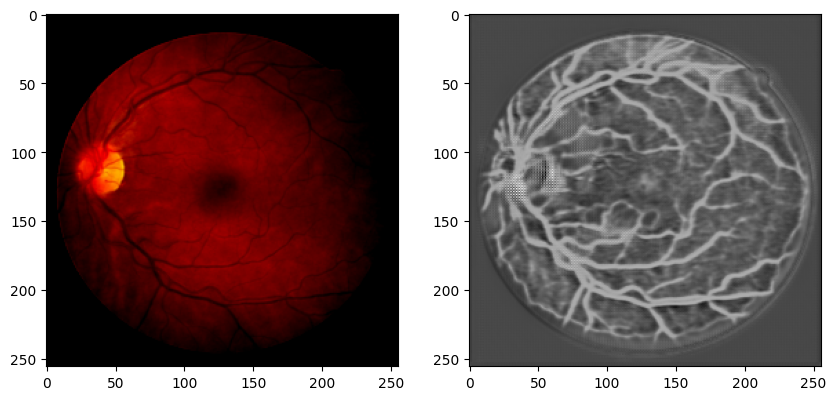

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


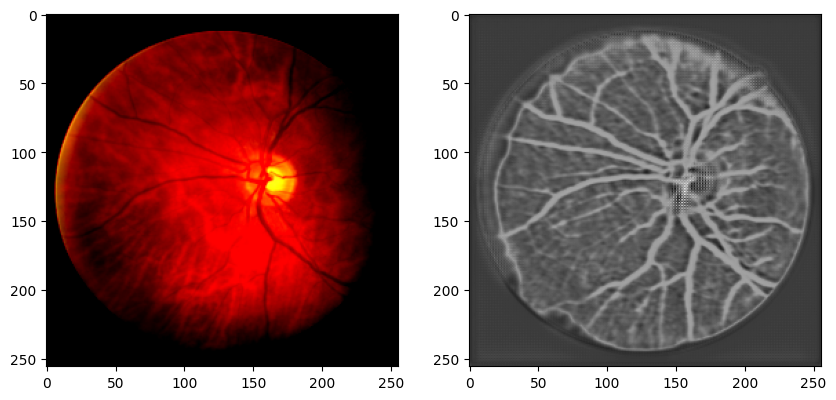

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


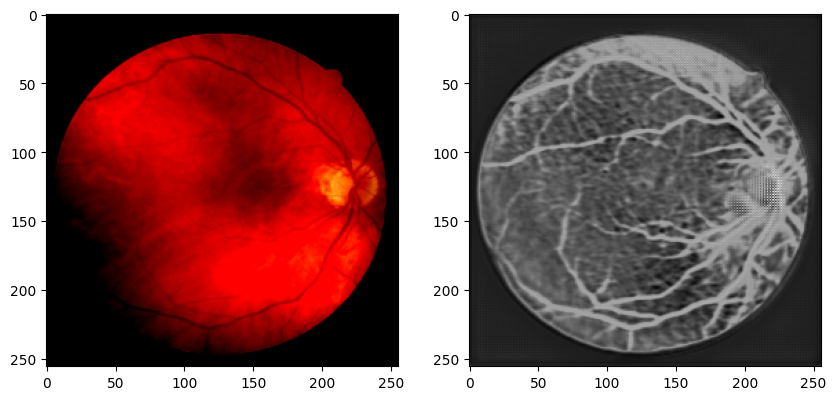

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


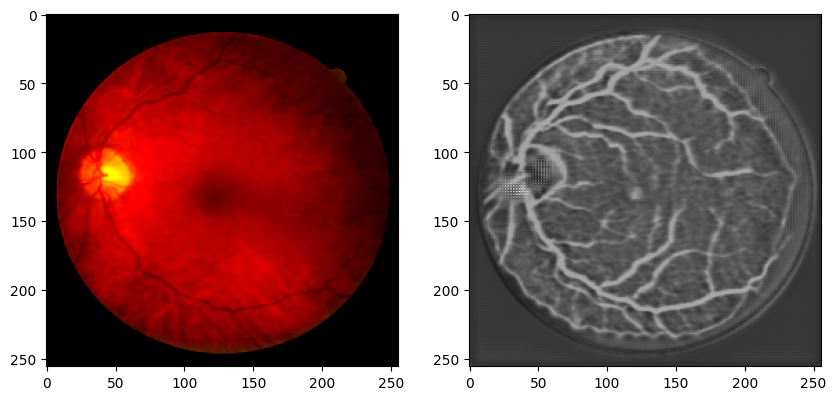

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


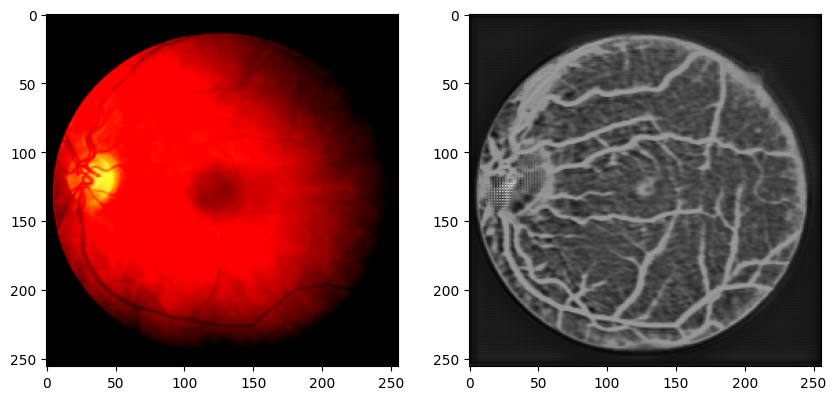

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


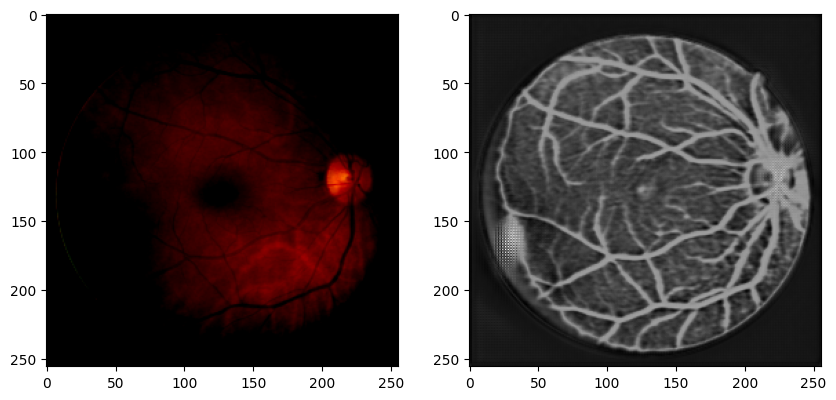

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


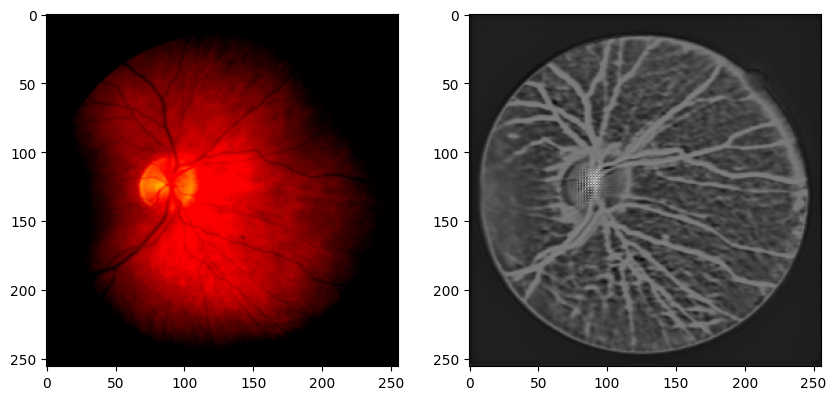

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


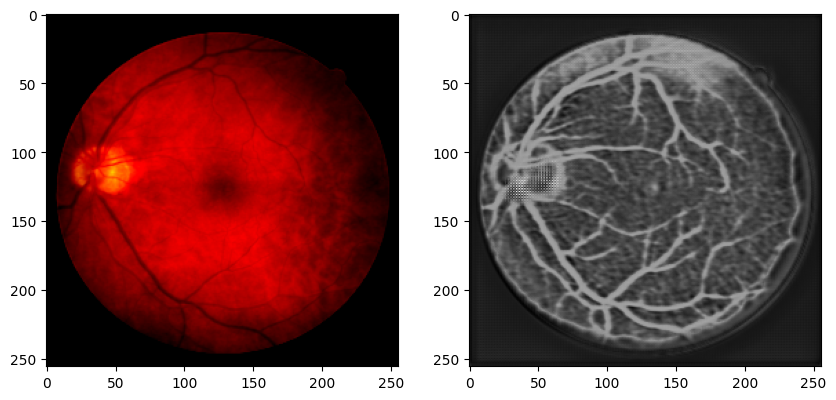

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


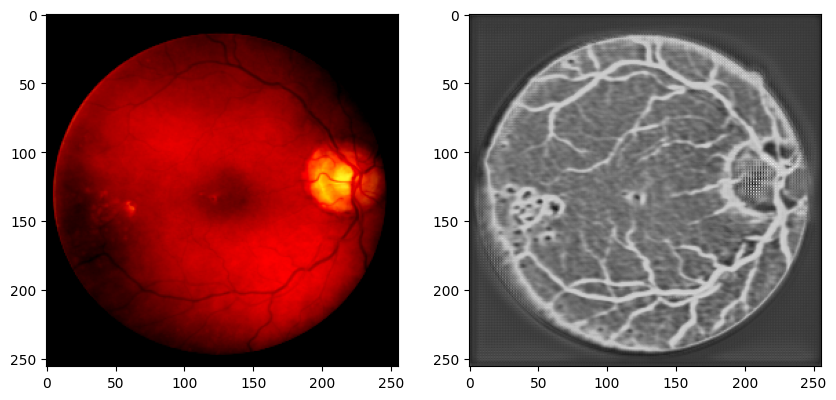

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


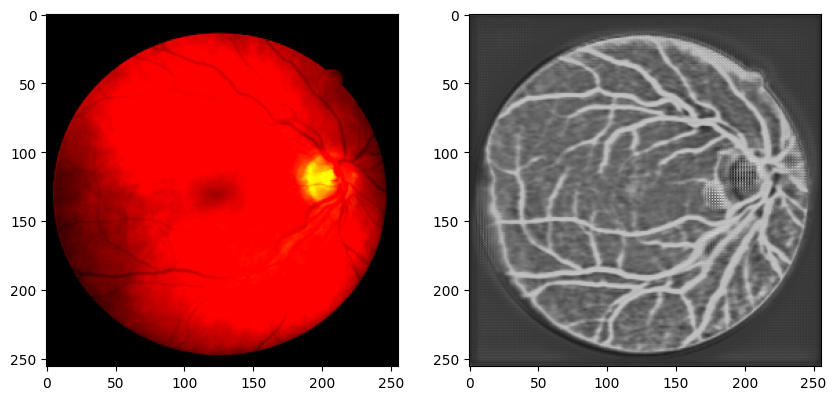

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


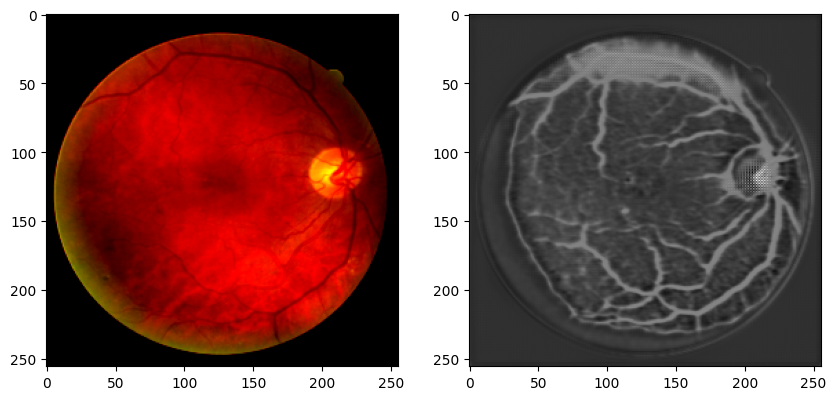

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


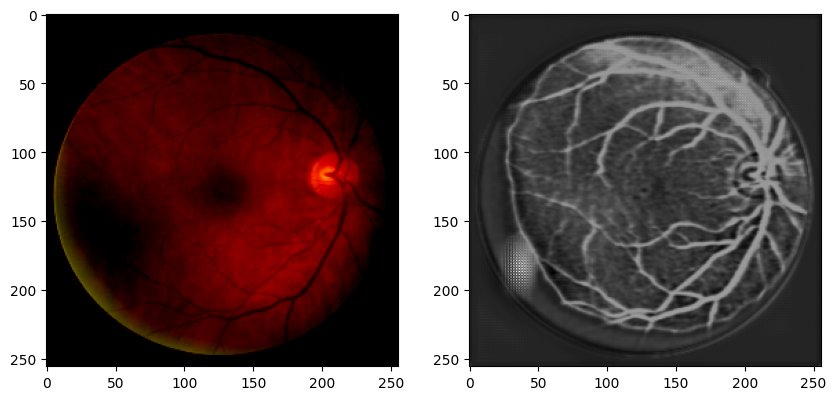

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


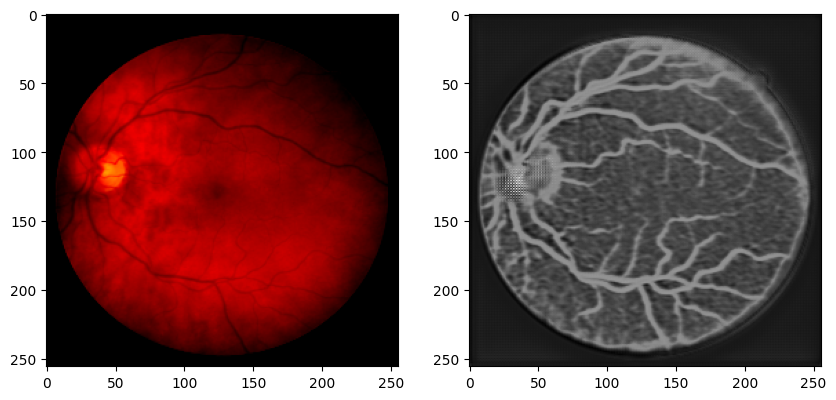

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


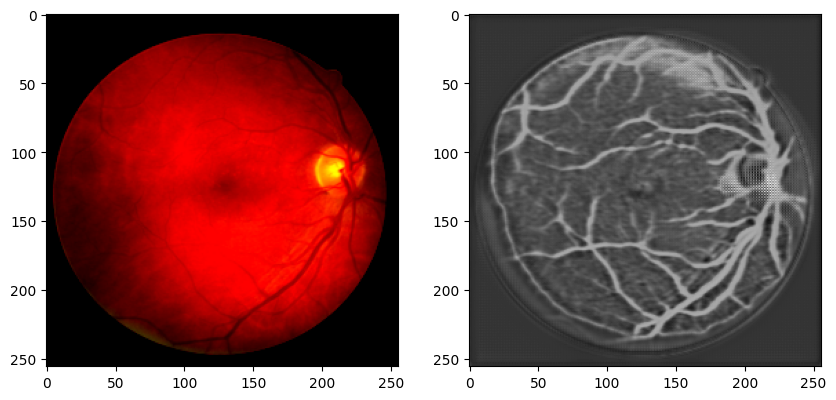

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


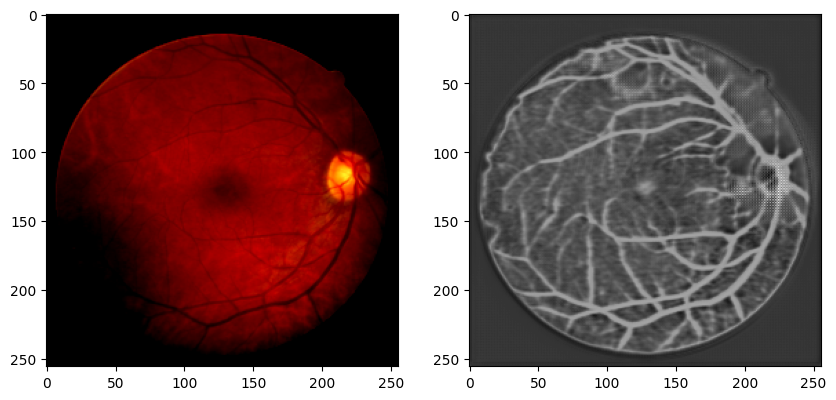

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


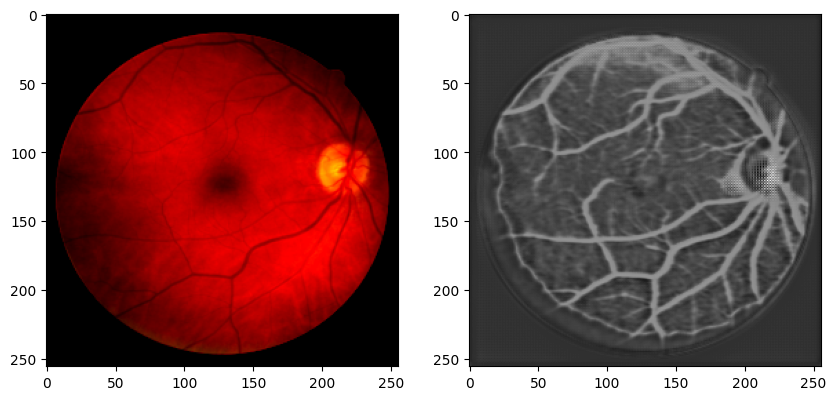

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


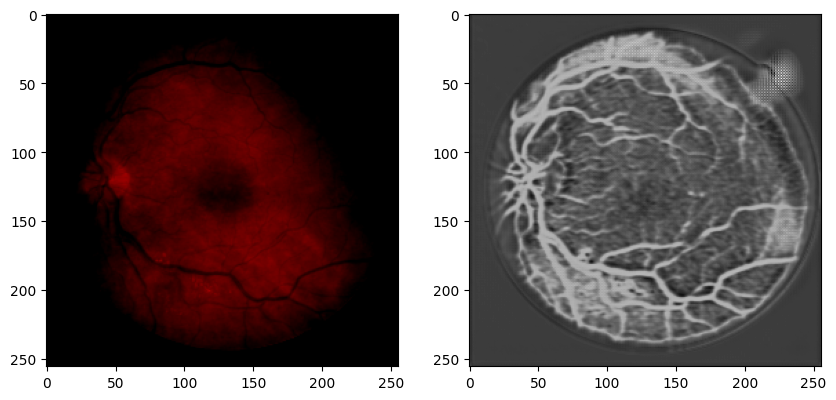

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


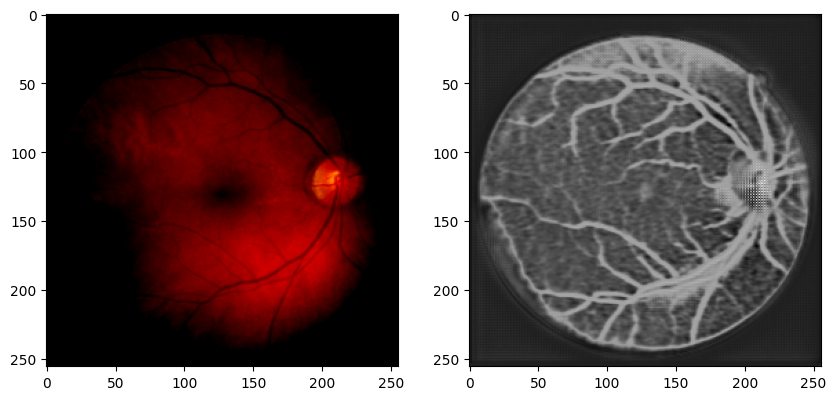

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


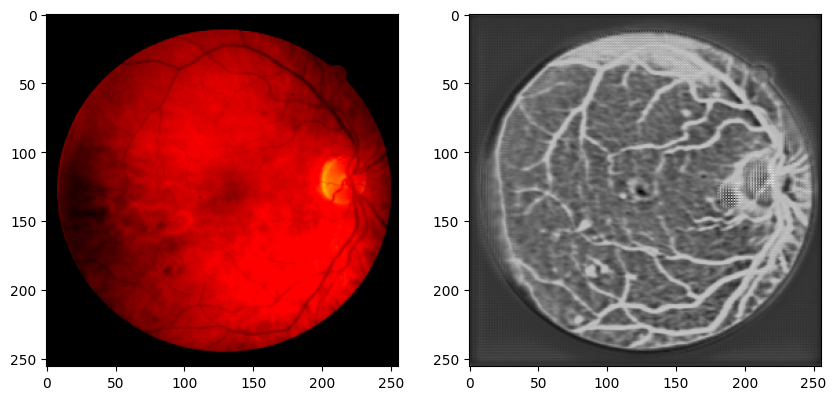

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


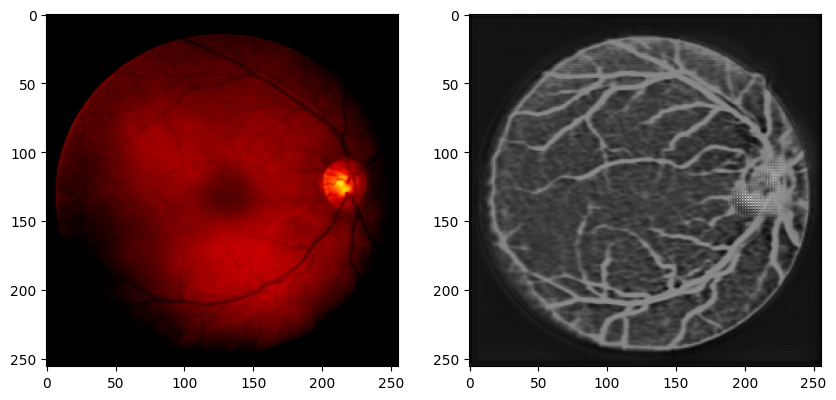

In [16]:
from glob import glob
for test_img_path in glob(test_img_dir + "/*"):
    img = transform(Image.open(test_img_path)).to(device).unsqueeze(0)

    mask = model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')

    plt.show()  
    plt.close("all")  